# A2: Gesture Recognizer

## Notebook Layout
1. Setup: imports, definitions, and classes

In [1]:
# This cell includes all imports and global definitions for this notebook.
# It should be run prior to any of the other cells.

import copy
import itertools
import ntpath
import os
import random
import sys

import ipywidgets
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy

from scipy import signal

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
            
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
# This cell contains our file handling and parsing related functions


# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = '{}_{}'.format(os.path.basename(path_to_dir), filenameParts[0])
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            for sample in [
                gestureTrial.accel.x, gestureTrial.accel.y, gestureTrial.accel.z,
                gestureTrial.gyro.x, gestureTrial.gyro.y, gestureTrial.gyro.z]:
                if maxArrayLength < len(sample):
                    maxArrayLength = len(sample)
                    print(maxArrayLength)
                    trialWithMostSensorEvents = gestureTrial           
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [2]:
# Load the data

jonTrials = parse_and_create_gesture_trials('./JonGestureLogs')
myTrials = parse_and_create_gesture_trials('./gesture_data')

mapGestureToTrials = copy.copy(jonTrials)
mapGestureToTrials.update(myTrials)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
108
120
Found 5 trials for 'JonGestureLogs_Midair Counter Clockwise O'
134
135
144
Found 5 trials for 'JonGestureLogs_Underhand Bowling'
Found 5 trials for 'JonGestureLogs_Baseball Throw'
Found 5 trials for 'JonGestureLogs_Midair Clockwise O'
Found 5 trials for 'JonGestureLogs_Midair Zorro Z'
Found 5 trials for 'JonGestureLogs_Forehand Tennis'
Found 5 trials for 'JonGestureLogs_Midair S'
146
Found 5 trials for 'JonGestureLogs_Backhand Tennis'
147
184
187
Found 5 trials for 'JonGestureLogs_Shake'
243
323
Found 5 trials for 'JonGestureLogs_At Rest'
Max trial length across all gesture is 'JonGestureLogs_At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 166 csv files in ./gesture_data
Found 12 gestures
103
104
111
348
Found 7 trials for 'gesture_data_Shake'
Found 6 trials for 'gesture_data_Backhand Tennis'
Found 6 trials for 'gesture_data_Midair S'
Found 7 trials for 'gesture_data_Underhand Bowling'
Found 8

## Visualization

To make visualizing a given task easier, we use a dropdown menu to select the gesture we're attempting to debug.  For convenience, two drop downs are available for comparing gestures side-by-side.

In [3]:
def DisplayDebugAccelVisualization(gestureName):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]

    trialNum = 1
    for trial in gestureTrials:
        axes[0][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].legend(loc='right')
    axes[0][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].legend(loc='right')
    axes[0][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].legend(loc='right')
    axes[0][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].legend(loc='right')
    axes[0][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].legend(loc='right')
    axes[1][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].legend(loc='right')
    axes[1][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].legend(loc='right')
    axes[1][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].legend(loc='right')
    axes[1][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));


interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

In [4]:
def DisplayDebugSpectrumVisualization(gestureName):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 15))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]

    for trial in gestureTrials:
        axes[0][0].specgram(trial.accel.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][1].specgram(trial.accel.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][2].specgram(trial.accel.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][3].specgram(trial.accel.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][0].specgram(trial.gyro.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][1].specgram(trial.gyro.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][2].specgram(trial.gyro.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][3].specgram(trial.gyro.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][0].psd(trial.accel.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][1].psd(trial.accel.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][2].psd(trial.accel.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][3].psd(trial.accel.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][0].psd(trial.gyro.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][1].psd(trial.gyro.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][2].psd(trial.gyro.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][3].psd(trial.gyro.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        
    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].set(xlabel='Time', ylabel='Frequency')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].set(xlabel='Time', ylabel='Frequency')
    
    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].set(xlabel='Time', ylabel='Frequency')
    
    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].set(xlabel='Time', ylabel='Frequency')
    
    axes[2][0].set_title(gestureName + " (Accel X)")
    axes[2][0].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][1].set_title(gestureName + " (Accel Y)")
    axes[2][1].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][2].set_title(gestureName + " (Accel Z)")
    axes[2][2].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][3].set_title(gestureName + " (Accel Mag)")
    axes[2][3].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][0].set_title(gestureName + " (Gyro X)")
    axes[3][0].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][1].set_title(gestureName + " (Gyro Y)")
    axes[3][1].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][2].set_title(gestureName + " (Gyro Z)")
    axes[3][2].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][3].set_title(gestureName + " (Gyro Mag)")
    axes[3][3].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
ipywidgets.interact(DisplayDebugSpectrumVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugSpectrumVisualization, gestureName=sorted(mapGestureToTrials.keys()));


interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

## Naive Matcher
After looking at the Acceleration, gyroscope, and frequency domain information about the given gestures, we can start making a basic shap matcher to attempt to classify gestures.

A simple smoothing pass is sufficient to get around 85+% accuracy.  This is, in part, because there is not likely to be a significant bias or trend over the course of gesture recording.

The non-periodic nature of most of the gestures meant that full spectral plots also werent significantly indicative of a particular gesture except in the case of highly periodic gestures like "shake"

JonGestureLogs_Midair Clockwise O 5.0/5.0 (100.0%)
JonGestureLogs_Baseball Throw 5.0/5.0 (100.0%)
JonGestureLogs_At Rest 5.0/5.0 (100.0%)
JonGestureLogs_Forehand Tennis 5.0/5.0 (100.0%)
JonGestureLogs_Shake 3.0/5.0 (60.0%)
JonGestureLogs_Midair Zorro Z 4.0/5.0 (80.0%)
JonGestureLogs_Underhand Bowling 3.0/5.0 (60.0%)
JonGestureLogs_Midair Counter Clockwise O 5.0/5.0 (100.0%)
JonGestureLogs_Backhand Tennis 5.0/5.0 (100.0%)
JonGestureLogs_Midair S 5.0/5.0 (100.0%)
45.0 of 50.0 correct: 0.9%


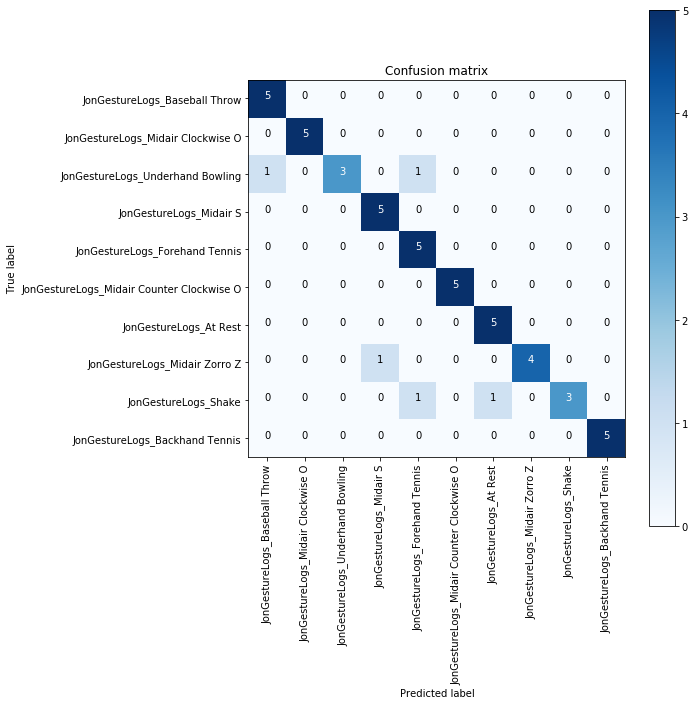

gesture_data_Midair Clockwise O 6.0/8.0 (75.0%)
gesture_data_Midair S 6.0/6.0 (100.0%)
gesture_data_Forehand Tennis 6.0/8.0 (75.0%)
gesture_data_Midair Counter Clockwise O 6.0/6.0 (100.0%)
gesture_data_Midair Zorro Z 6.0/6.0 (100.0%)
gesture_data_Shake 6.0/7.0 (85.71428571428571%)
gesture_data_At Rest 7.0/8.0 (87.5%)
gesture_data_Backhand Tennis 5.0/6.0 (83.33333333333334%)
gesture_data_Conducting 7.0/7.0 (100.0%)
gesture_data_Chopping 5.0/6.0 (83.33333333333334%)
gesture_data_Underhand Bowling 4.0/7.0 (57.14285714285714%)
gesture_data_Baseball Throw 7.0/8.0 (87.5%)
71.0 of 83.0 correct: 0.8554216867469879%


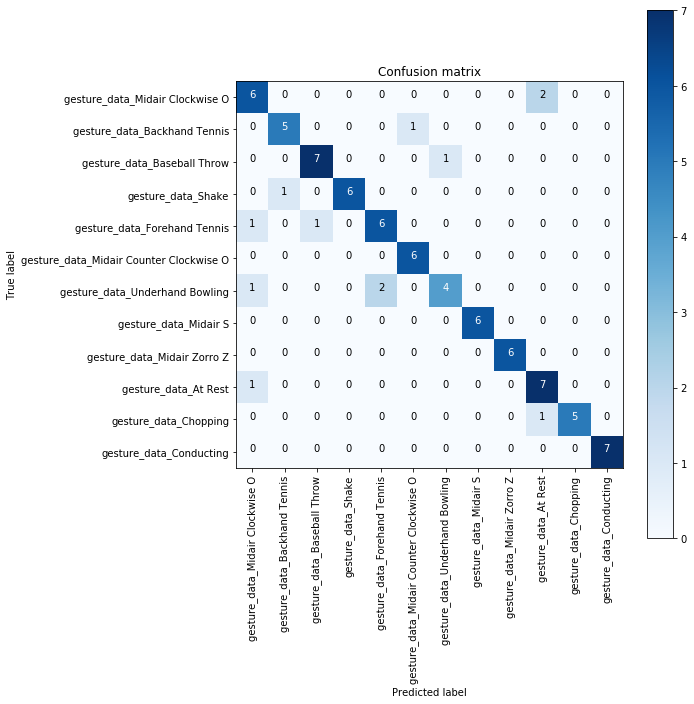

In [5]:
def Smooth(arr, factor=15):
    """ From: http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
    s = np.r_[arr[factor-1:0:-1], arr, arr[-2:-factor-1:-1]]
    w = np.ones(factor, 'd')
    return np.convolve(w/w.sum(), s, mode='valid')

def DiffAxis(first, second):
    """Calculate the diff between two raw numpy arrays"""
    #Smooth the signals:
    first = Smooth(first)
    second = Smooth(second)
   
    first = first / np.linalg.norm(first)
    second = second / np.linalg.norm(second)
    return scipy.spatial.distance.euclidean(first, second)


def CalculateDifference(trial1, trial2):
    """Calculates the difference between two Trial objects."""
    diff = 0.0
    diff += DiffAxis(trial1.accel.x, trial2.accel.x)
    diff += DiffAxis(trial1.accel.y, trial2.accel.y)
    diff += DiffAxis(trial1.accel.z, trial2.accel.z)
    diff += DiffAxis(trial1.accel.mag, trial2.accel.mag)
    diff += DiffAxis(trial1.accel.x, trial2.accel.x)
    diff += DiffAxis(trial1.accel.y, trial2.accel.y)
    diff += DiffAxis(trial1.accel.z, trial2.accel.z)
    diff += DiffAxis(trial1.accel.mag, trial2.accel.mag)
    
    return diff


def Match(trial, candidates):
    """Determines the activity label for a given trial."""
    minDiff = 100000000000000.0  # A very large number
    match = None
    for candidate in candidates:
        diff = CalculateDifference(trial, candidate)
        if diff < minDiff:
            minDiff = diff
            match = candidate
    return 'UNKNOWN' if not match else match.gestureName


def PrintResults(results):
    correct = 0.0
    total = 0.0
    for truth, prediction_list in results.items():
        label = truth
        local_correct = 0.
        local_total = 0.
        for prediction in prediction_list:
            total += 1.0
            local_total += 1.0
            if truth == prediction:
                correct += 1.0
                local_correct += 1.0
            
        print ('{} {}/{} ({}%)'.format(truth, local_correct, local_total, (local_correct / local_total * 100)))
                
    print('{} of {} correct: {}%'.format(correct, total, (correct / total)))    


def PlotConfusionMatrix(results,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    true_values = []
    predictions = []
    labels = set()

    for truth, prediction_list in results.items():
        for prediction in prediction_list:
            true_values.append(truth)
            predictions.append(prediction)
            labels.add(truth)
            labels.add(prediction)
                
    labels = list(labels)
    
    cm = confusion_matrix(true_values, predictions, labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Run the test.
def Test(trials, k=5):
    # Create the randomized k-fold.
    flat_list = [trial for trials in trials.values() for trial in trials]
    random.shuffle(flat_list)
    results = {}
    
    folds = {
        1: flat_list[:10],
        2: flat_list[10:20],
        3: flat_list[20:30],
        4: flat_list[30:40],
        5: flat_list[40:],
    }

    for fold, trial_list in folds.items():
        training_data = []
        for i, training_trials in folds.items():
            if i == fold:
                continue
            training_data.extend(training_trials)
        for trial in trial_list:
            if trial.gestureName not in results:
                results[trial.gestureName] = []
            results[trial.gestureName].append(Match(trial, training_data))
    return results

jonResults = Test(jonTrials)
PrintResults(jonResults)
PlotConfusionMatrix(jonResults)

myResults = Test(myTrials)
PrintResults(myResults)
PlotConfusionMatrix(myResults)

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [6]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

(array([0, 2]),)
['apple' 'apple']


In [7]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

5
7


{'newVar': 7, 'testVar': 5}

In [8]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
1 2 3 4 5 6 7 8 9 10
6 7 8 9 10


In [9]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

['a', 'c', 'd']
['d', 'c', 'a']
['d', 'a']


In [10]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

[1, 2, 3, 4]
[1, 2, 3, 5]
[4, 5]
[1, 2, 3]


In [11]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

array([ 0,  0, -1, -5, -5])

In [12]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

6.324555320336759
6.324555320336759


[36.38639667 26.30308802 42.49330174 27.37378074 34.67204378 18.83095135
  2.68194592 23.32565222 47.7843621  32.30249367 39.68087877 28.63552375
 21.37178122 29.01497321  9.10151687 26.86840377 34.99147428 44.36688878
 10.72195098 49.84562379 49.53096625 26.64959439 14.87355498 34.21523538
 22.52555869 36.30757121 27.44489782  5.05443161 15.72578853  6.02458041
 11.14751546 40.59475151  7.82027445  2.34009634 49.409894   45.30850287
  8.24738024 18.81439845 46.52193514 14.08177909 24.1461186  14.19336607
 10.74215138 33.68258873 15.85254961 14.95670625  8.40320896  4.89383168
  2.94358983 10.95237944]


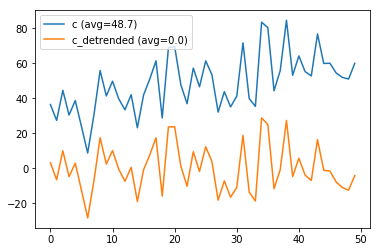

In [13]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
#axes.plot(a)
#axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


Confusion matrix, without normalization
[[2 0 0]
 [0 1 1]
 [1 0 2]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.5        0.5       ]
 [0.33333333 0.         0.66666667]]


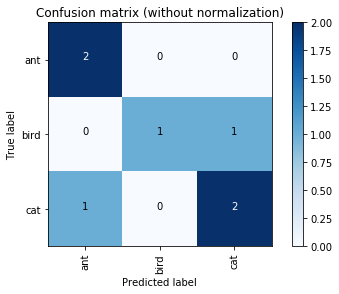

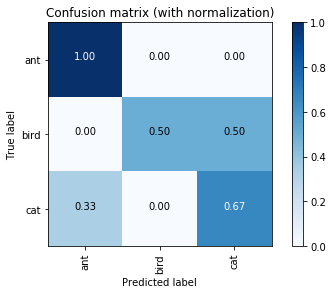

In [14]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

## Experiments and Trials
This is some backmatter for recording different experiments with respect to data processing and model training.

In [15]:
def DisplayDebugAccelVisualization(gestureName):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]
    
    avg_x = np.zeros([len(gestureTrials[0].accel.x)], dtype=float)
    avg_y = np.zeros([len(gestureTrials[0].accel.y)], dtype=float)
    avg_z = np.zeros([len(gestureTrials[0].accel.z)], dtype=float)
    for trial in gestureTrials:
        avg_x += trial.accel.x
        avg_y += trial.accel.y
        avg_z += trial.accel.z

    avg_x = avg_x / len(gestureTrials)
    avg_y = avg_y / len(gestureTrials)
    avg_z = avg_z / len(gestureTrials)
    axes[0][0].plot(avg_x / np.linalg.norm(avg_x), alpha=0.9, label="Average")
    axes[0][1].plot(avg_y / np.linalg.norm(avg_y), alpha=0.9, label="Average")
    axes[0][2].plot(avg_z / np.linalg.norm(avg_z), alpha=0.9, label="Average")   

    trialNum = 1
    for trial in gestureTrials:
        axes[0][0].plot(trial.accel.x / np.linalg.norm(trial.accel.x),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][1].plot(trial.accel.y / np.linalg.norm(trial.accel.y),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][2].plot(trial.accel.z / np.linalg.norm(trial.accel.z),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][3].plot(trial.accel.mag / np.linalg.norm(trial.accel.mag),
                        alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][0].plot(np.gradient(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][1].plot(np.gradient(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][2].plot(np.gradient(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][3].plot(np.gradient(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].legend(loc='right')
    axes[0][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].legend(loc='right')
    axes[0][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].legend(loc='right')
    axes[0][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].legend(loc='right')
    axes[0][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].legend(loc='right')
    axes[1][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].legend(loc='right')
    axes[1][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].legend(loc='right')
    axes[1][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].legend(loc='right')
    axes[1][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));


interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))